# Neural Architecture Utilities
Author: Jin Yeom (jinyeom@utexas.edu)

This notebook consists of various tools for designing architectures of neural networks.

## Receptive field calculator

In [5]:
def rf(out_dim: int, 
       kernel: int, 
       stride: int) -> int:
    return (out_dim - 1) * stride + kernel

In [16]:
# for discriminator network in CycleGAN

out_dim = f(1, 4, 1)
conv_3 = f(out_dim, 4, 1)
conv_2 = f(conv_3, 4, 2)
conv_1 = f(conv_2, 4, 2)
in_dim = f(conv_1, 4, 2)

print(f"receptive field of each output neuron: {in_dim}x{in_dim}")

receptive field of each output neuron: 70x70


## PyTorch model visualization

In [7]:
from graphviz import Digraph
import torch
from torch.autograd import Variable

def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
                    
    add_nodes(var.grad_fn)
    return dot

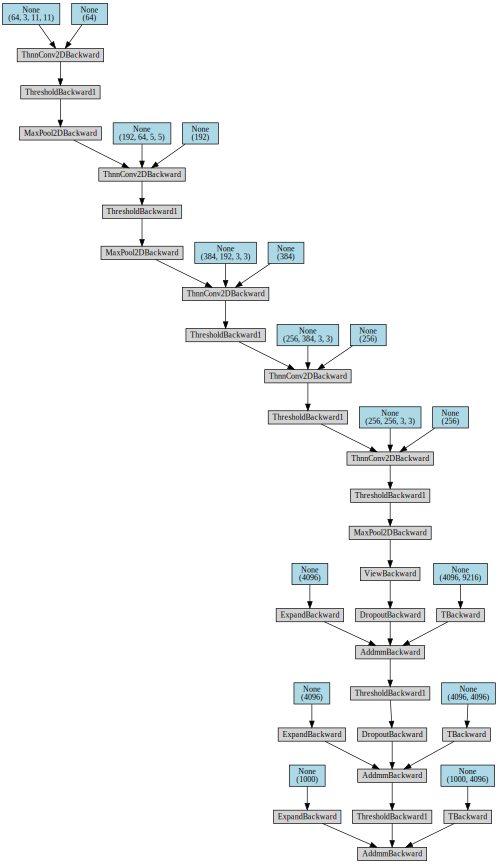

In [11]:
from torchvision import models

inputs = torch.randn(1, 3, 224, 224)
model = models.alexnet()
y = model(Variable(inputs))

make_dot(y, model.state_dict())